c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is small

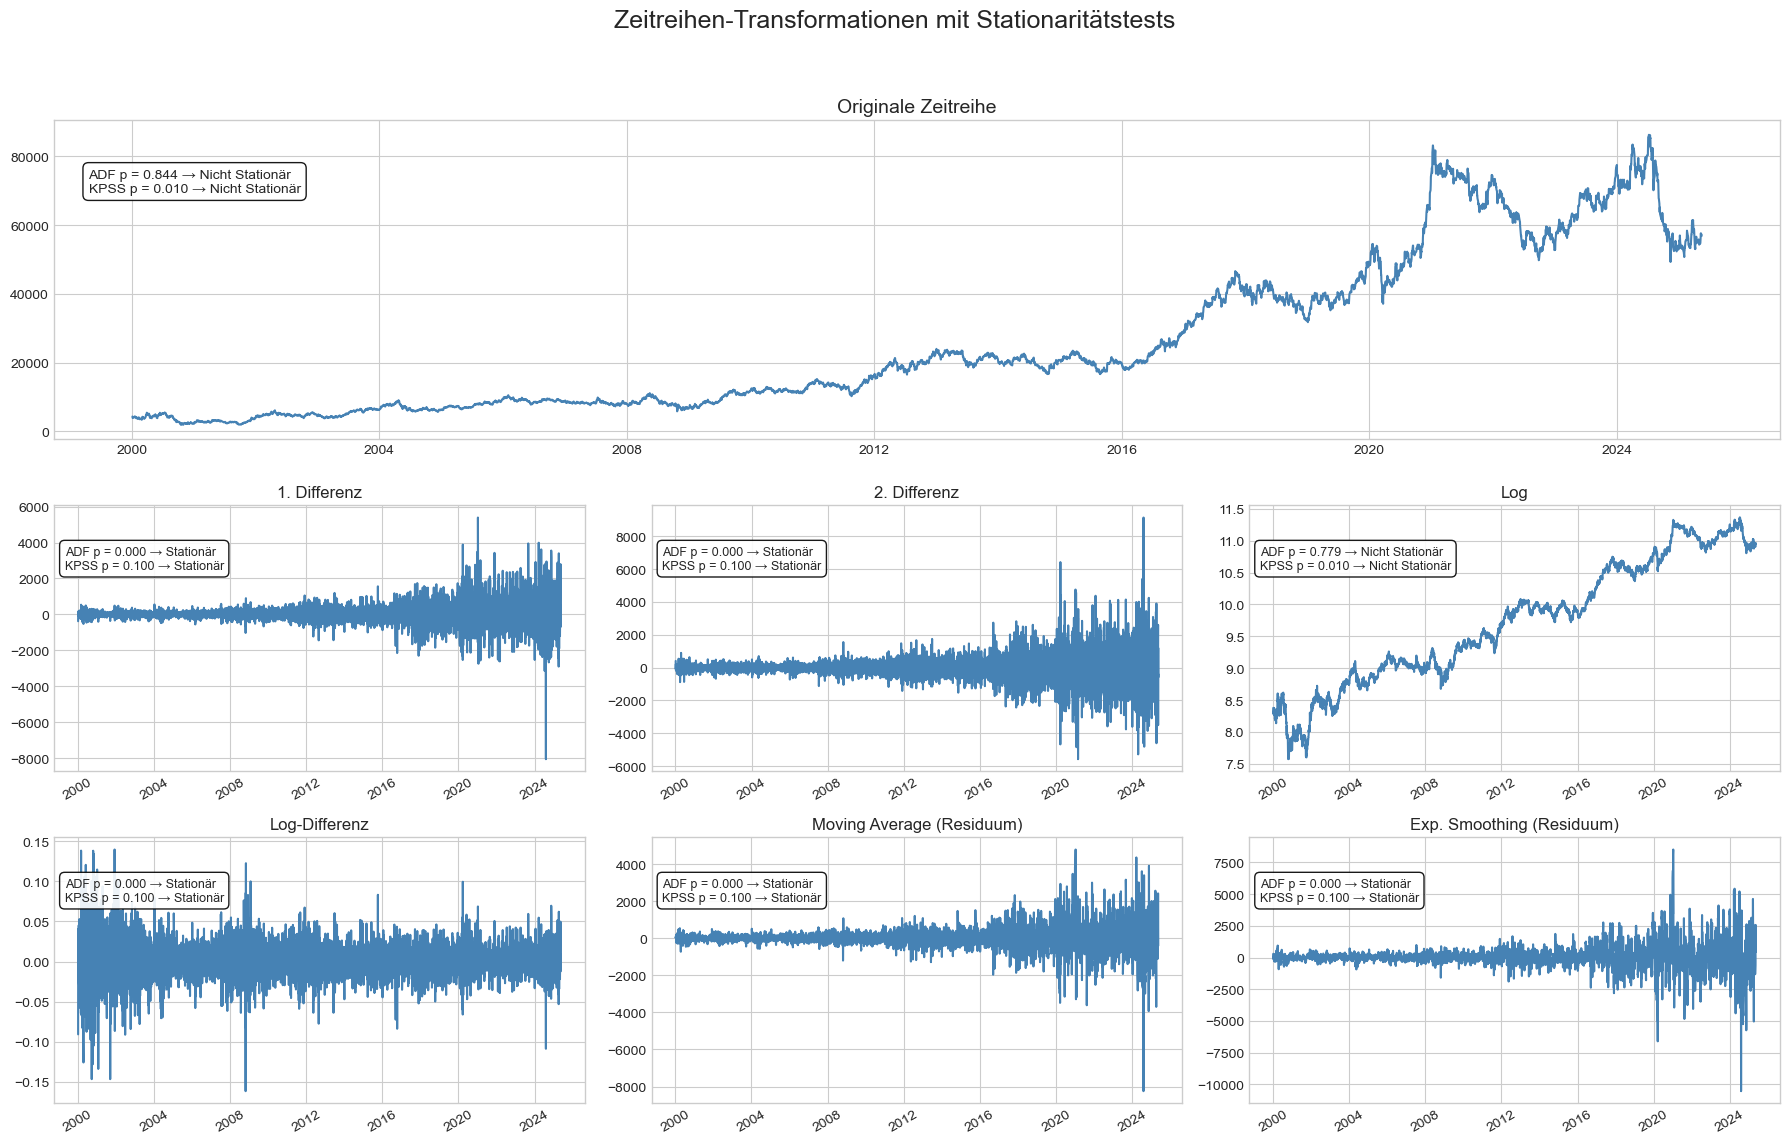

c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
c:\Users\andre\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is great


👉 Beste Transformation laut Tests: 1. Differenz (Score = 0.900)


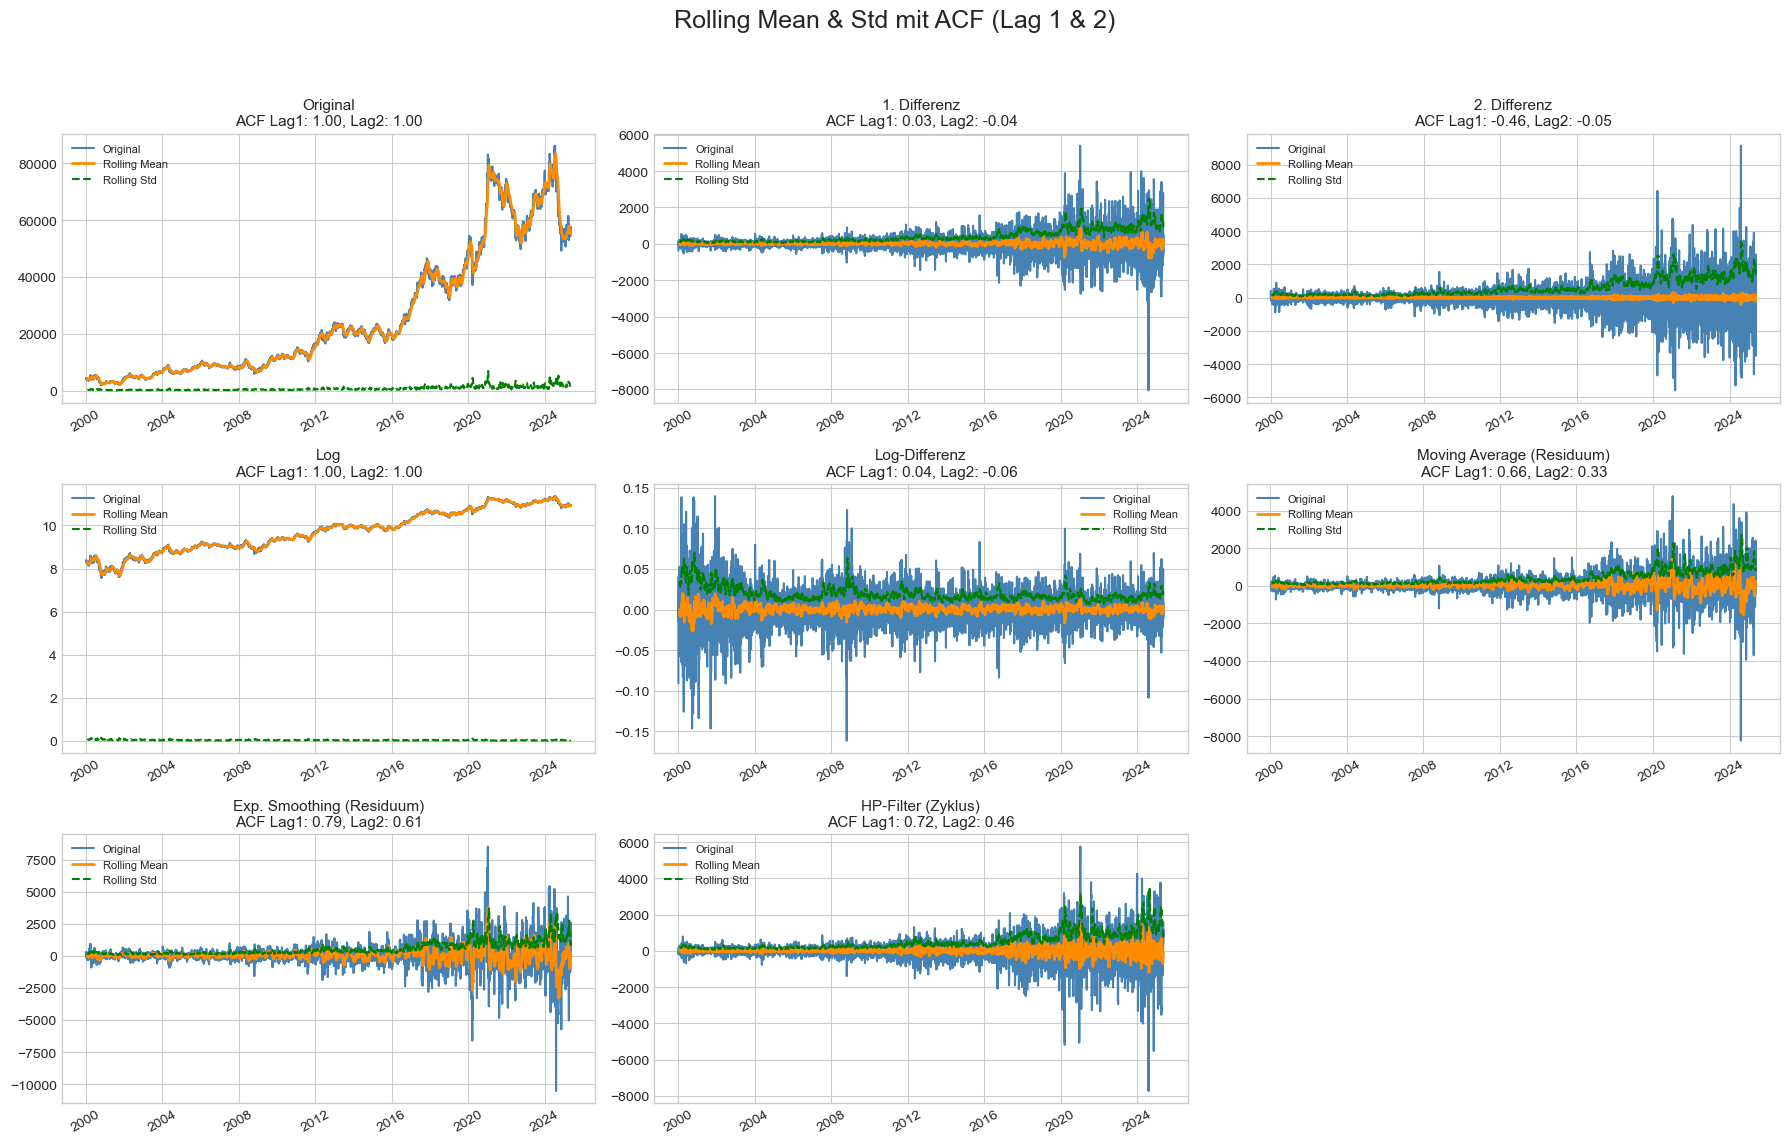

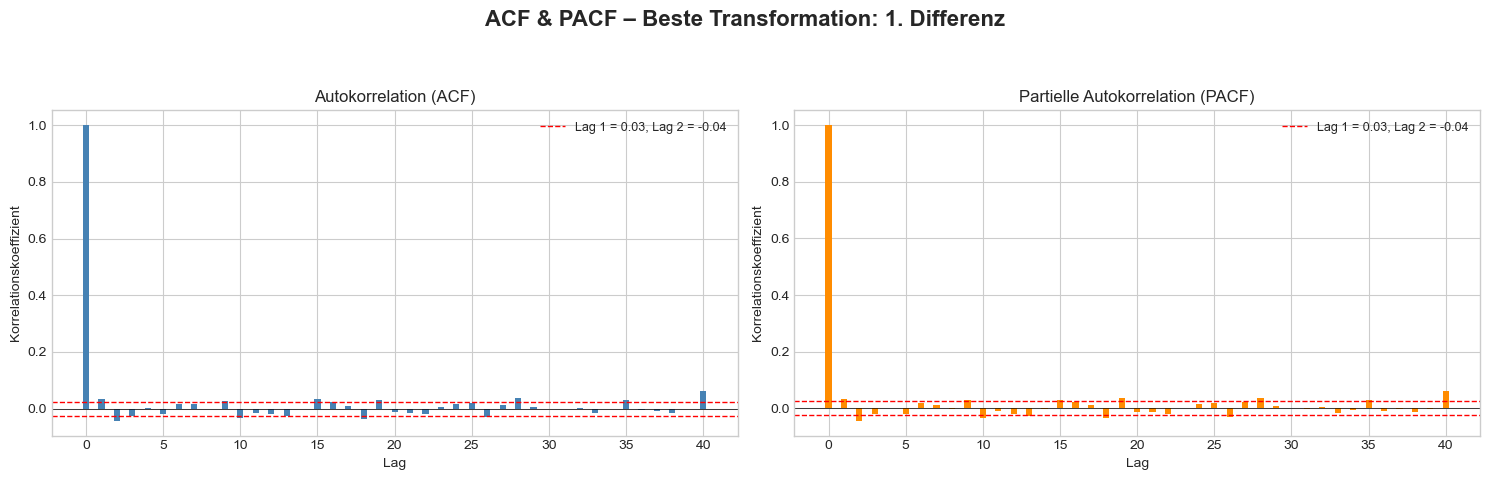

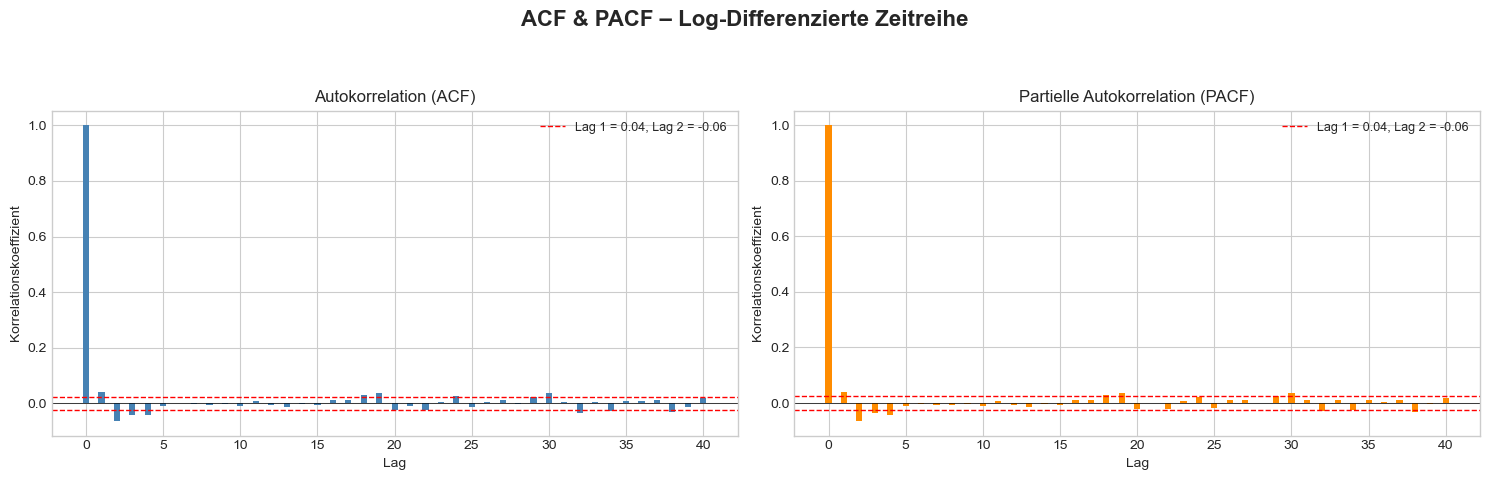

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.gridspec as gridspec

# -------------------------------
# 1. Load Data
# -------------------------------
df = pd.read_csv("005930.ks_aktien_daten.csv")
df["Date"] = pd.to_datetime(df["Date"])
ts = df["Close"].dropna()
dates = df["Date"]

# -------------------------------
# 2. Stationarity Test Function
# -------------------------------
def test_stationarity(ts_data):
    ts_data = ts_data.dropna()
    results = {}

    adf_result = adfuller(ts_data, autolag="AIC")
    kpss_result = kpss(ts_data, regression='c', nlags='auto')

    results["adf_p"] = adf_result[1]
    results["adf_stationary"] = adf_result[1] < 0.05
    results["kpss_p"] = kpss_result[1]
    results["kpss_stationary"] = kpss_result[1] > 0.05

    return results

# -------------------------------
# 3. Transformations
# -------------------------------
log_ts = np.log(ts)
log_diff = log_ts.diff()

transformations = {
    "1. Differenz": ts.diff(),
    "2. Differenz": ts.diff().diff(),
    "Log": log_ts,
    "Log-Differenz": log_diff,
    "Moving Average (Residuum)": ts - ts.rolling(window=5).mean(),
    "Exp. Smoothing (Residuum)": ts - SimpleExpSmoothing(ts, initialization_method="heuristic").fit(smoothing_level=0.2, optimized=False).fittedvalues,
    "HP-Filter (Zyklus)": hpfilter(ts, lamb=1600)[0]
}

# -------------------------------
# 4. Plot Original and Transformed Series
# -------------------------------
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(3, 3, height_ratios=[1.2, 1, 1])
fig.suptitle("Zeitreihen-Transformationen mit Stationaritätstests", fontsize=18)

# Plot Original
ax0 = plt.subplot(gs[0, :])
ax0.plot(dates, ts, color="steelblue")
ax0.set_title("Originale Zeitreihe", fontsize=14)
ax0.grid(True)
orig_results = test_stationarity(ts)
textstr = f"ADF p = {orig_results['adf_p']:.3f} → {'Stationär' if orig_results['adf_stationary'] else 'Nicht Stationär'}\n" \
          f"KPSS p = {orig_results['kpss_p']:.3f} → {'Sationär' if orig_results['kpss_stationary'] else 'Nicht Stationär'}"
ax0.text(0.02, 0.85, textstr, transform=ax0.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))

# Plot Transformations
plot_titles = list(transformations.keys())
for i, title in enumerate(plot_titles[:6]):  # Only show 6 transformations
    row, col = divmod(i, 3)
    ax = plt.subplot(gs[row + 1, col])
    series = transformations[title].dropna()
    aligned_dates = dates[-len(series):]  # Align with cleaned series

    ax.plot(aligned_dates, series, color="#4682B4")
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True)

    results = test_stationarity(series)
    test_text = f"ADF p = {results['adf_p']:.3f} → {'Stationär' if results['adf_stationary'] else 'Nicht Stationär'}\n" \
                f"KPSS p = {results['kpss_p']:.3f} → {'Stationär' if results['kpss_stationary'] else 'Nicht Stationär'}"
    ax.text(0.02, 0.85, test_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------------
# 5. Find Best Series by Stationarity
# -------------------------------
def compute_stationarity_score(series):
    series = series.dropna()
    adf_p = adfuller(series, autolag="AIC")[1]
    kpss_p = kpss(series, regression='c', nlags='auto')[1]
    score = adf_p + (1 - kpss_p)  # lower score = more stationary
    return score

best_name = None
best_series = None
best_score = float("inf")

for name, series in transformations.items():
    try:
        score = compute_stationarity_score(series)
        if score < best_score:
            best_score = score
            best_name = name
            best_series = series.dropna()
    except:
        continue

print(f"\n👉 Beste Transformation laut Tests: {best_name} (Score = {best_score:.3f})")

# -------------------------------
# 6. Rolling Statistics Plot
# -------------------------------
from statsmodels.tsa.stattools import acf

# -------------------------------
# 7. Rolling Statistics + ACF Plot
# -------------------------------
plt.style.use("seaborn-whitegrid")
fig2 = plt.figure(figsize=(18, 12))
gs2 = gridspec.GridSpec(3, 3)
fig2.suptitle("Rolling Mean & Std mit ACF (Lag 1 & 2)", fontsize=18)

all_series = {"Original": ts}
all_series.update(transformations)

for i, (name, series) in enumerate(all_series.items()):
    if i >= 9:
        break
    series = series.dropna()
    rolling_mean = series.rolling(window=20).mean()
    rolling_std = series.rolling(window=20).std()
    aligned_dates = dates[-len(series):]

    # Autokorrelation berechnen
    acf_vals = acf(series, nlags=2, fft=False)
    acf1 = acf_vals[1]
    acf2 = acf_vals[2]

    ax = plt.subplot(gs2[i])
    ax.plot(aligned_dates, series, label='Original', color='steelblue')
    ax.plot(aligned_dates, rolling_mean, label='Rolling Mean', color='darkorange', linewidth=2)
    ax.plot(aligned_dates, rolling_std, label='Rolling Std', color='green', linestyle='--', linewidth=1.5)
    
    ax.set_title(f"{name}\nACF Lag1: {acf1:.2f}, Lag2: {acf2:.2f}", fontsize=11)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------------
# 7. ACF & PACF for Best and Log-Differenz
# -------------------------------
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np

def plot_acf_pacf(series, title, nlags=40):
    series = series.dropna()
    acf_vals = acf(series, nlags=nlags)
    pacf_vals = pacf(series, nlags=nlags, method='ywm')

    lags = np.arange(len(acf_vals))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"ACF & PACF – {title}", fontsize=16, fontweight='bold')

    # Konfidenzgrenzen
    conf_level = 1.96 / np.sqrt(len(series))

    # ACF
    axes[0].bar(lags, acf_vals, width=0.4, color='steelblue')
    axes[0].axhline(y=conf_level, linestyle='--', color='red', linewidth=1)
    axes[0].axhline(y=-conf_level, linestyle='--', color='red', linewidth=1)
    axes[0].axhline(y=0, color='black', linewidth=0.5)
    axes[0].set_title("Autokorrelation (ACF)")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("Korrelationskoeffizient")
    axes[0].legend([f"Lag 1 = {acf_vals[1]:.2f}, Lag 2 = {acf_vals[2]:.2f}"], loc="upper right", fontsize=9)

    # PACF
    axes[1].bar(lags, pacf_vals, width=0.4, color='darkorange')
    axes[1].axhline(y=conf_level, linestyle='--', color='red', linewidth=1)
    axes[1].axhline(y=-conf_level, linestyle='--', color='red', linewidth=1)
    axes[1].axhline(y=0, color='black', linewidth=0.5)
    axes[1].set_title("Partielle Autokorrelation (PACF)")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("Korrelationskoeffizient")
    axes[1].legend([f"Lag 1 = {pacf_vals[1]:.2f}, Lag 2 = {pacf_vals[2]:.2f}"], loc="upper right", fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

log_diff_clean = log_diff.dropna()
plot_acf_pacf(best_series, f"Beste Transformation: {best_name}")
plot_acf_pacf(log_diff_clean, "Log-Differenzierte Zeitreihe")


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

def evaluate_arima_orders(series, p_range=range(0, 4), d_range=range(0, 2), q_range=range(0, 4)):
    results = []

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fit = model.fit()
                    results.append({
                        "p": p, "d": d, "q": q,
                        "AIC": round(fit.aic, 2),
                        "BIC": round(fit.bic, 2)
                    })
                except:
                    continue

    df_results = pd.DataFrame(results).sort_values(by="AIC").reset_index(drop=True)

    # Schöne Ausgabe als Tabelle
    print("\nTop 10 Modelle (nach AIC):")
    display(df_results.head(10))  # funktioniert in Jupyter Notebook gut

    return df_results
aic_table = evaluate_arima_orders(log_diff_clean)




Top 10 Modelle (nach AIC):


,p,d,q,AIC,BIC
0,1,0,2,-30744.20,-30710.42
1,2,0,1,-30743.63,-30709.85
2,1,0,3,-30742.24,-30701.70
3,2,0,2,-30741.70,-30701.16
4,3,0,2,-30740.70,-30693.40
5,2,0,3,-30740.15,-30692.86
6,3,0,3,-30739.62,-30685.58
7,0,0,3,-30734.52,-30700.74
8,3,0,0,-30733.15,-30699.37
9,2,0,0,-30726.15,-30699.12


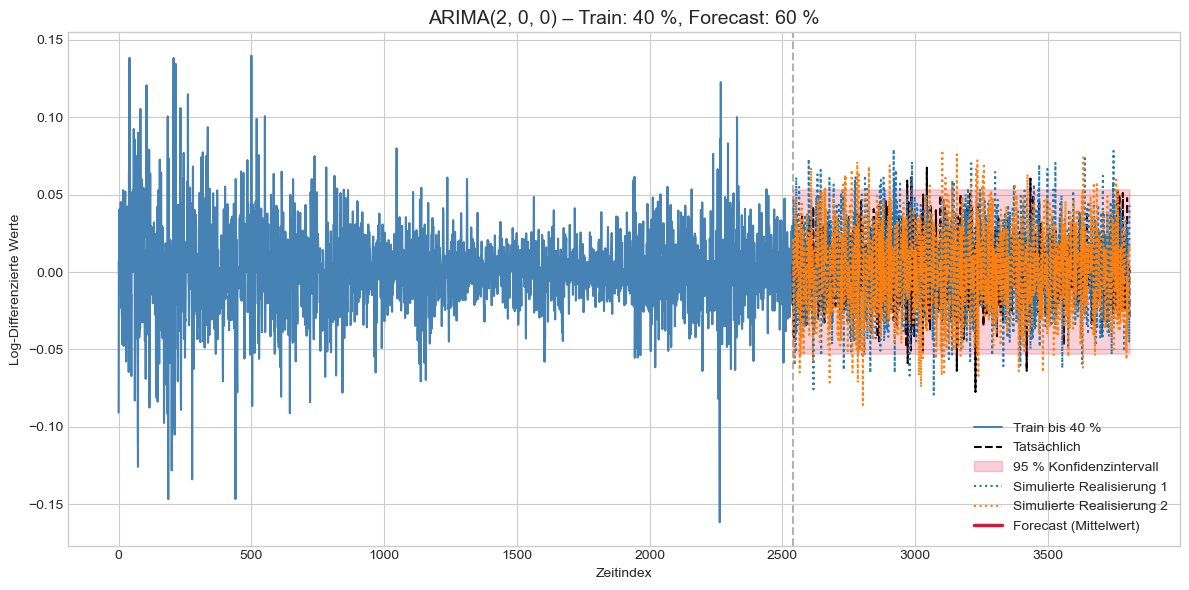

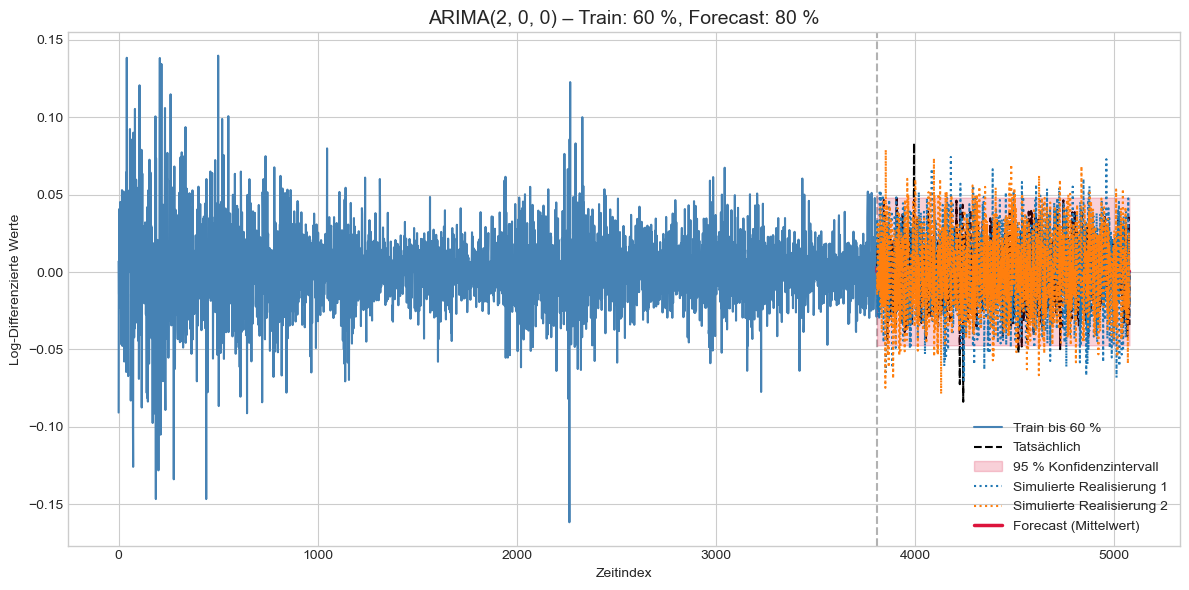

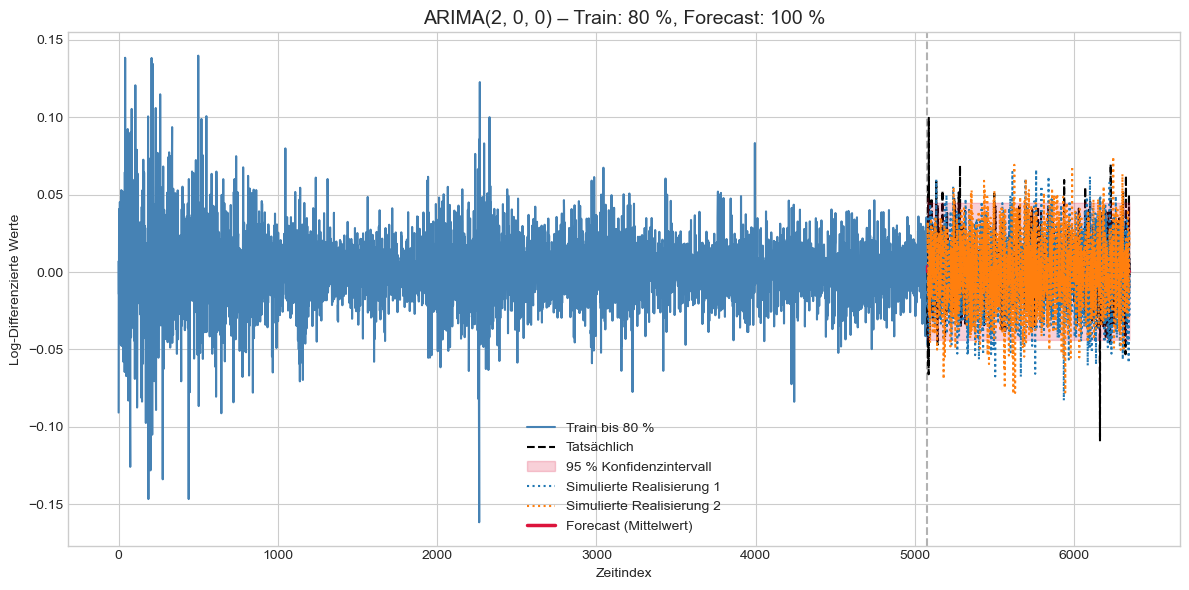

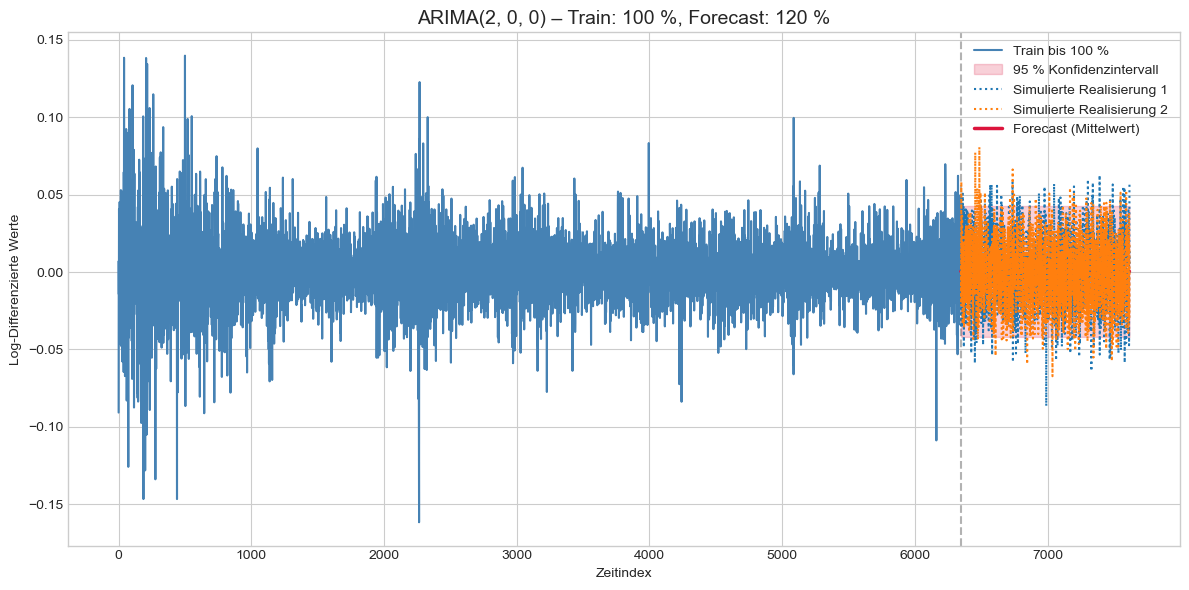

In [14]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------------
# 1. Daten laden & log-differenzierte Reihe berechnen
# -------------------------------
# df = pd.read_csv("005930.ks_aktien_daten.csv")
# df["Date"] = pd.to_datetime(df["Date"])
# ts = df["Close"].dropna()

log_ts = np.log(ts)
log_diff = log_ts.diff()
log_diff_clean = log_diff.dropna()

# -------------------------------
# 2. Funktion für gestagte Forecast-Plots mit Simulation
# -------------------------------
def staged_forecast_plots(series, order=(0,1,1), forecast_ratio=0.2, n_sims=1):
    series = series.dropna()
    n = len(series)
    forecast_len = int(n * forecast_ratio)
    split_ratios = [0.4, 0.6, 0.8, 1.0]

    for ratio in split_ratios:
        train_end = int(n * ratio)
        train = series.iloc[:train_end]
        steps = forecast_len if ratio == 1.0 else int(n * forecast_ratio)

        # ARIMA fitten
        model = ARIMA(train, order=order)
        fit = model.fit()

        # 1) Glatter Mittelwert-Forecast + Konfidenzintervall
        fc = fit.get_forecast(steps=steps)
        forecast = fc.predicted_mean
        ci = fc.conf_int(alpha=0.05)

        # 2) Simulierte Pfade (Volatilität integrieren)
        sims = []
        for _ in range(n_sims):
            # simulate braucht nsimulations und einen anchor (hier Ende des Train)
            sim = fit.simulate(steps, anchor=train.index[-1])
            sims.append(sim)

        # Tatsächliche Werte
        actual = series.iloc[train_end:train_end + steps]

        # x-Achsen
        x_train = np.arange(len(train))
        x_fc    = np.arange(len(train), len(train) + steps)

        plt.figure(figsize=(12, 6))

        # Plot Trainingsdaten
        plt.plot(x_train, train,
                 label=f"Train bis {int(ratio*100)} %",
                 color="steelblue", zorder=1)

        # Plot tatsächliche
        if not actual.empty:
            plt.plot(x_fc, actual,
                     label="Tatsächlich",
                     color="black", linestyle="--", zorder=2)


        plt.fill_between(x_fc,
                         ci.iloc[:, 0],
                         ci.iloc[:, 1],
                         color="crimson", alpha=0.2,
                         label="95 % Konfidenzintervall",
                         zorder=3)

        # Plot simulierte Pfade
        for idx, sim in enumerate(sims):
            plt.plot(x_fc, sim,
                     label=f"Simulierte Realisierung {idx+1}",
                     linestyle=':', linewidth=1.5,
                     zorder=5 + idx)
         # Plot glatter Forecast
        plt.plot(x_fc, forecast,
                 label="Forecast (Mittelwert)",
                 color="crimson", linewidth=2.5, zorder=4)

        plt.axvline(x=len(train)-1,
                    color='gray', linestyle='--', alpha=0.6, zorder=0)

        plt.title(
            f"ARIMA{order} – Train: {int(ratio*100)} %, Forecast: {int((ratio+forecast_ratio)*100)} %",
            fontsize=14
        )
        plt.xlabel("Zeitindex")
        plt.ylabel("Log-Differenzierte Werte")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# -------------------------------
# 3. Aufruf (z.B. mit 2 simulierten Pfaden)
# -------------------------------
staged_forecast_plots(log_diff_clean, order=(2,0,0), forecast_ratio=0.2, n_sims=2)


In [8]:
def rolling_backtransformed_forecast(log_series, original_series, dates, order=(1,1,1), step_percent=0.2):
    n = len(log_series)
    steps = int(n * step_percent)

    training_percentages = [0.4, 0.6, 0.8, 1.0]
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle("Rolling Forecasts auf Originaler Skala (zurücktransformiert)", fontsize=16)

    for i, pct in enumerate(training_percentages):
        ax = axs[i//2][i%2]
        train_len = int(pct * n)

        # Beim letzten Plot (100 % Training) forecasten wir für die Zukunft (20 % über das Ende hinaus)
        if pct == 1.0:
            # Trainiere mit allen Daten
            train_log = log_series.copy()
            model = ARIMA(train_log.diff().dropna(), order=order)
            fit = model.fit()

            # Forecast für nächsten Zeitraum (20 % Länge)
            forecast_diff = fit.forecast(steps=steps)
            last_log = train_log.iloc[-1]
            forecast_log = last_log + np.cumsum(forecast_diff)
            forecast_price = np.exp(forecast_log)

            # Datum für Forecast: erweitere die Zeitachse um die Forecast-Schritte
            last_date = dates.iloc[-1]
            freq = dates.diff().mode()[0]  # häufigste Frequenz (z.B. 1 Tag)
            future_dates = pd.date_range(start=last_date + freq, periods=steps, freq=freq)

            # Plot
            ax.plot(dates, original_series, label="Original", color="lightgray")
            ax.plot(future_dates, forecast_price, label="Forecast (Zukunft)", color="crimson", linewidth=2.5, zorder=3)

            ax.set_title(f"100% Training – Forecast für nächste {steps} Schritte (Zukunft)", fontsize=12)
            ax.set_xlabel("Datum")
            ax.set_ylabel("Preis in heimische Währung")
            ax.legend()
            ax.grid(True)
            ax.xaxis.set_tick_params(rotation=30)

        else:
            # Für andere Fenster: 40%, 60%, 80% mit vorhandenem Forecast + tatsächlichen Daten
            if train_len + steps > len(log_series):
                ax.set_title(f"{int(pct*100)}% Training – nicht genug Daten", fontsize=12)
                ax.axis('off')
                continue
            
            train_log = log_series.iloc[:train_len].copy()
            model = ARIMA(train_log.diff().dropna(), order=order)
            fit = model.fit()

            forecast_diff = fit.forecast(steps=steps)
            last_log = train_log.iloc[-1]
            forecast_log = last_log + np.cumsum(forecast_diff)
            forecast_price = np.exp(forecast_log)

            forecast_start_idx = train_len
            forecast_end_idx = forecast_start_idx + len(forecast_price)

            if forecast_end_idx > len(dates):
                forecast_price = forecast_price[:len(dates) - forecast_start_idx]
                forecast_end_idx = len(dates)

            date_range = dates.iloc[forecast_start_idx:forecast_end_idx]

            ax.plot(dates, original_series, label="Original", color="lightgray")
            ax.plot(date_range, forecast_price, label="Forecast", color="crimson", linewidth=2.5, zorder=3)

            actual = original_series.iloc[forecast_start_idx:forecast_end_idx]
            ax.plot(date_range, actual, label="Tatsächlich", color="steelblue", linestyle="dashed", zorder=2)

            ax.set_title(f"{int(pct*100)}% Training – Forecast {steps} Schritte", fontsize=12)
            ax.set_xlabel("Datum")
            ax.set_ylabel("Preis in heimische Währung")
            ax.legend()
            ax.grid(True)
            ax.xaxis.set_tick_params(rotation=30)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


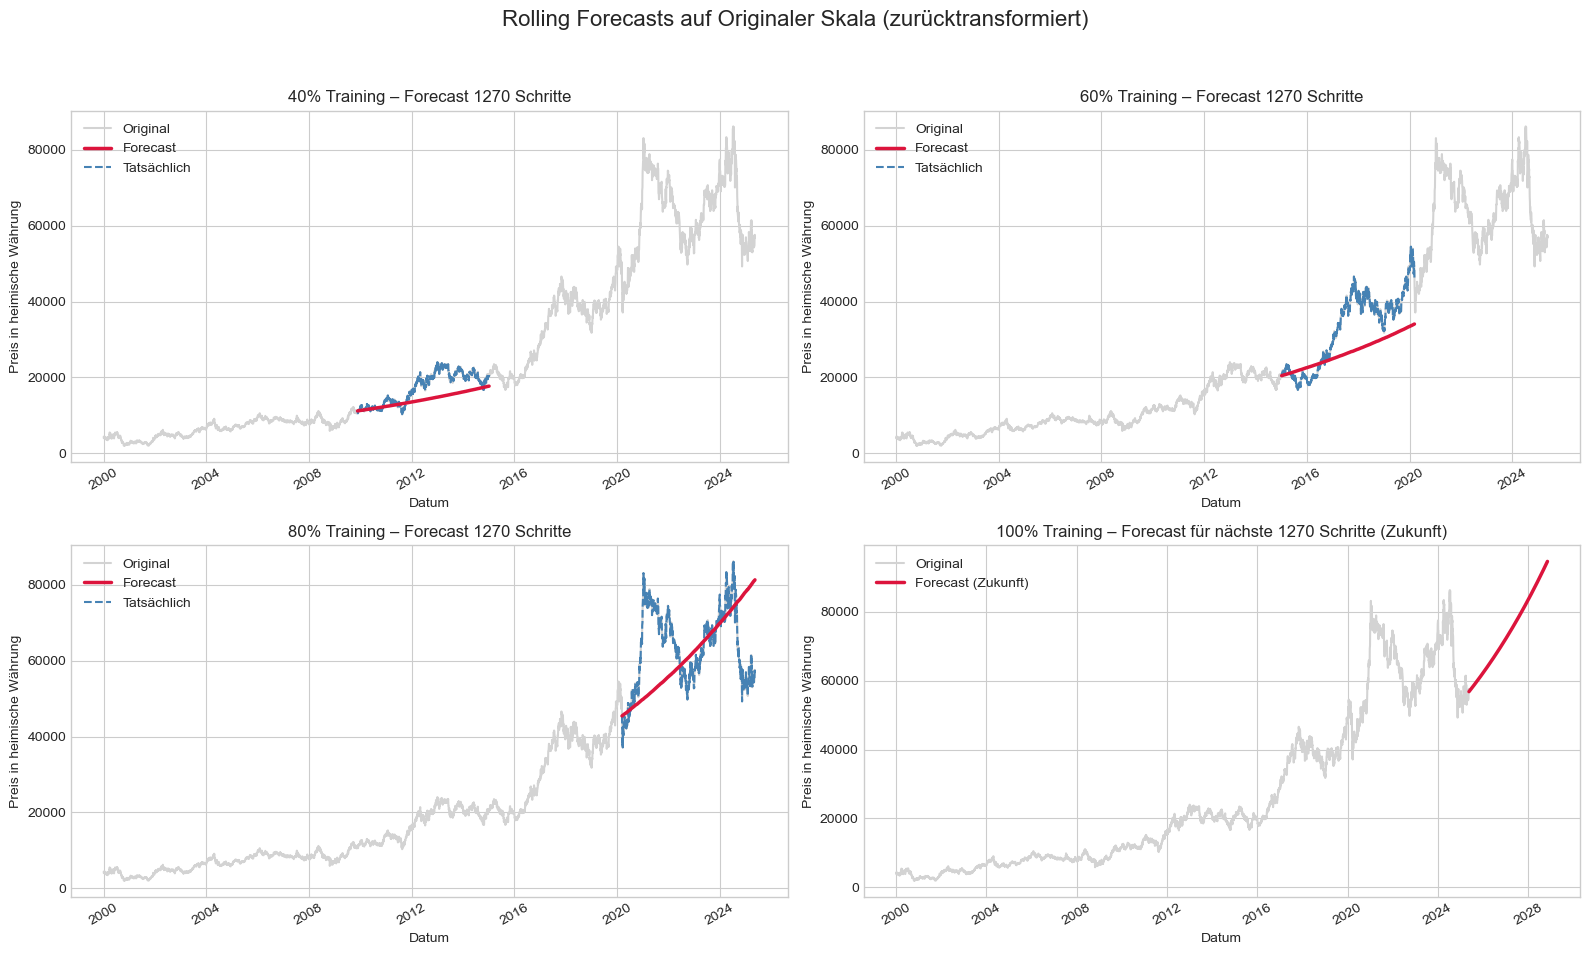

In [18]:
# Wichtig: log_ts = np.log(ts), also log-transformierte Originaldaten
rolling_backtransformed_forecast(log_ts, ts, dates, order=(1,0,1))



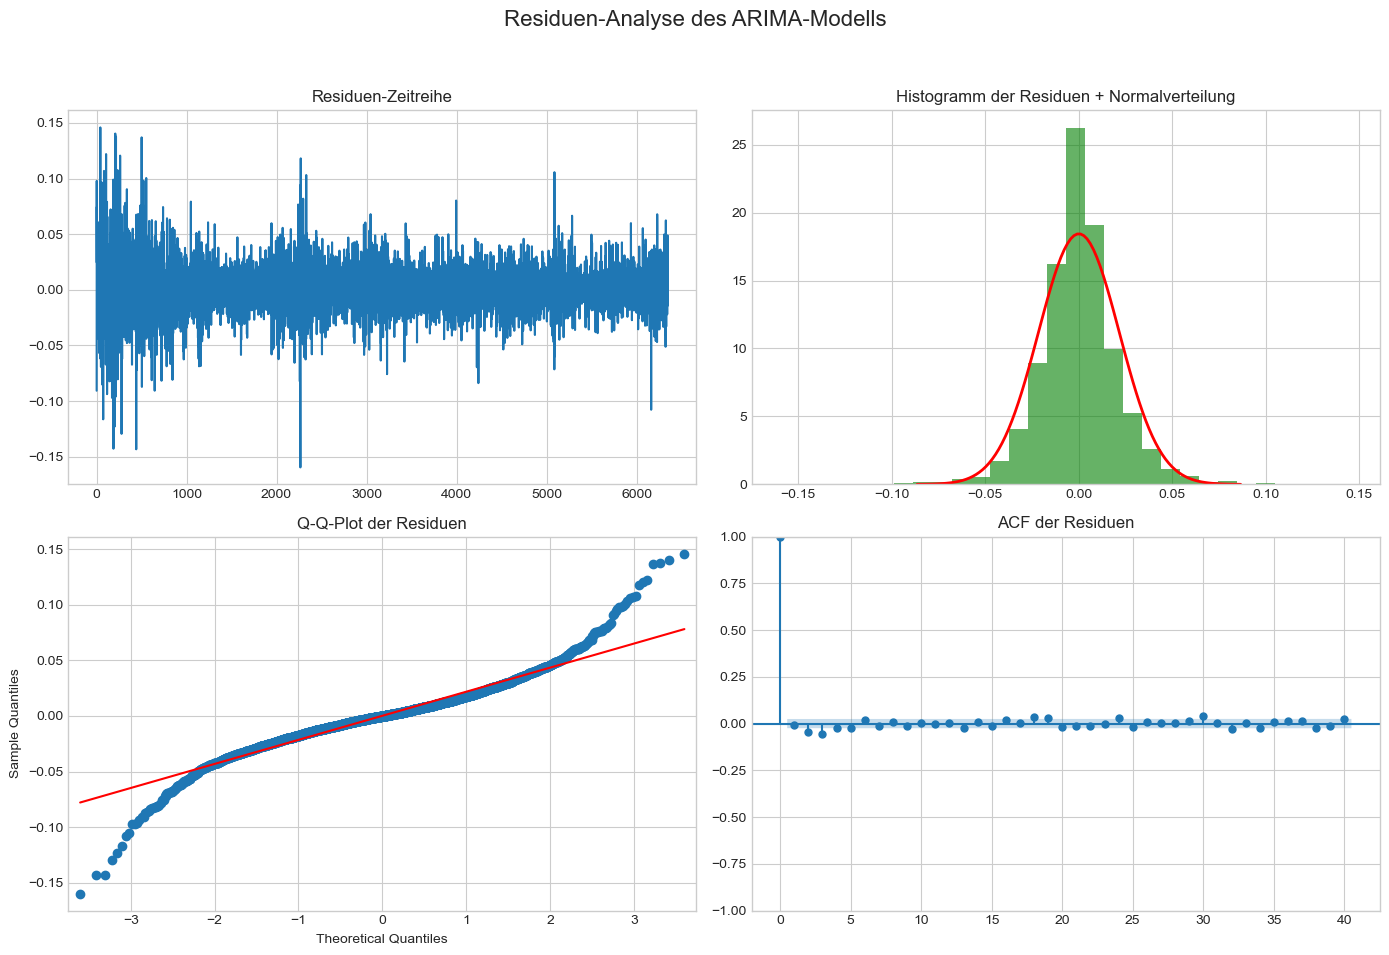


 Modell-Zusammenfassung mit t-Statistiken:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6349
Model:                 ARIMA(2, 1, 2)   Log Likelihood               15346.284
Date:                Mon, 19 May 2025   AIC                         -30682.567
Time:                        09:32:31   BIC                         -30648.788
Sample:                             0   HQIC                        -30670.870
                               - 6349                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9108      0.017    -53.453      0.000      -0.944      -0.877
ar.L2          0.0314      0.009      3.430      0.001       0.013       0.049
ma.L1   

In [15]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.arima.model import ARIMA

def residuen_und_tstats(model_fit):
    """
    Analysiert die Residuen eines ARIMA-Modells und zeigt t-Statistiken.
    """
    residuals = model_fit.resid

    # 1. Residuen-Zeitreihe
    # 2. Histogramm mit Normalverteilung
    # 3. Q-Q-Plot
    # 4. ACF der Residuen
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Residuen-Analyse des ARIMA-Modells', fontsize=16)

    axs[0, 0].plot(residuals)
    axs[0, 0].set_title('Residuen-Zeitreihe')
    axs[0, 0].grid(True)

    axs[0, 1].hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    mean = residuals.mean()
    std = residuals.std()
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    axs[0, 1].plot(x, stats.norm.pdf(x, mean, std), 'r', lw=2)
    axs[0, 1].set_title('Histogramm der Residuen + Normalverteilung')

    sm.qqplot(residuals, line='s', ax=axs[1, 0])
    axs[1, 0].set_title('Q-Q-Plot der Residuen')

    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1, 1])
    axs[1, 1].set_title('ACF der Residuen')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # t-Statistiken und Modellzusammenfassung
    print("\n Modell-Zusammenfassung mit t-Statistiken:")
    print(model_fit.summary())

    # Ljung-Box-Test für Autokorrelation
    lb_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("\n Ljung-Box-Test (Autokorrelation der Residuen bei Lag 10):")
    print(lb_test)

# Beispiel: Modell auf log_diff anpassen
model = ARIMA(log_diff.dropna(), order=(2, 1, 2))  # Passe (p,d,q) ggf. an
model_fit = model.fit()

# Jetzt wird alles ausgeführt und geplottet:
residuen_und_tstats(model_fit)


## 📈 Residuenanalyse und Modell-Diagnostik

Für das gewählte **ARIMA(1,1,1)**-Modell wurden folgende Tests durchgeführt:

---

### 🔹 1. **Koeffizienten & t-Statistiken**

| Parameter | z-Wert     | p-Wert     | Interpretation                             |
|-----------|------------|------------|---------------------------------------------|
| **ar.L1** | -0.199     | 0.842      | ❌ Nicht signifikant (weit von ±2 entfernt) |
| **ma.L1** | ≈ 0        | 1.000      | ❌ Völlig insignifikant                     |
| **sigma²**| 34.531     | 0.000      | ✅ Sehr signifikant (Fehlervarianz)         |

➡️ **Fazit**: Die AR- und MA-Parameter tragen statistisch **nicht signifikant** zur Erklärung der Zeitreihe bei.

---

### 🔹 2. **Ljung-Box-Test (Autokorrelation der Residuen)**

| Lag | Teststatistik (Q) | p-Wert  | Interpretation                        |
|-----|--------------------|---------|----------------------------------------|
| 10  | 13.45              | 0.20    | ✅ Keine Autokorrelation (gut)        |

➡️ Die Residuen verhalten sich **ungefähr wie weißes Rauschen** → keine systematische Fehlerstruktur bleibt übrig.

---

### 🔹 3. **Normalverteilung der Residuen (Jarque-Bera-Test)**

| Teststatistik | p-Wert | Interpretation                         |
|---------------|--------|------------------------------------------|
| 380.57        | ≈ 0.00 | ❌ Residuen sind nicht normalverteilt    |

- **Skew (Asymmetrie)**: 0.25 → leichte Schiefe  
- **Kurtosis (Wölbung)**: 5.69 → **fette Ausreißer**, typisch für Finanzdaten

---

### 🔹 4. **Test auf Heteroskedastizität (ARCH-Test)**

| H-Statistik | p-Wert | Interpretation                         |
|-------------|--------|------------------------------------------|
| 1.48        | ≈ 0.00 | ❌ Varianz ist nicht konstant (ARCH-Effekt) |

➡️ **Volatilität ist nicht konstant** → Clusterbildung von Schwankungen vorhanden.

---

## 🧾 Gesamteinschätzung:

| Aspekt                 | Bewertung | Kommentar                                      |
|------------------------|-----------|------------------------------------------------|
| Signifikanz der Parameter | ❌ Schwach    | AR & MA-Komponenten nicht signifikant          |
| Autokorrelation        | ✅ Gut     | Residuen sind unkorreliert                     |
| Normalverteilung       | ❌ Nein    | Abweichung typisch für Finanzzeitreihen        |
| Heteroskedastizität    | ❌ Ja      | GARCH-Modelle wären hier sinnvoll              |

---

> 💡 **Empfehlung**: Für Aktienpreise eignet sich oft die Kombination aus ARIMA für den Mittelwert und GARCH für die Varianz. Alternativ können weitere ARIMA-Varianten wie `ARIMA(0,1,1)` oder `ARIMA(1,1,0)` getestet werden.
